# Task 2 NER 

In [93]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from langdetect import detect
import seaborn as sns

data = load_dataset('argilla/medical-domain')['train']
df = data.to_pandas()

df['label'] = df.prediction.apply(lambda x: x[0]['label'])

For this task, we only work with English texts.

In [97]:
df['language'] = df['text'].apply(lambda x: detect(x))
unique_languages = df['language'].unique()

print('Number of non-english texts:', sum(df['language'] != 'en'))
english_texts = df[df['language'] == 'en']
df['text'].head()

Number of non-english texts: 13


0    PREOPERATIVE DIAGNOSIS:,  Iron deficiency anem...
1    CLINICAL INDICATION:  ,Normal stress test.,PRO...
2    FINDINGS:,Axial scans were performed from L1 t...
3    PREOPERATIVE DIAGNOSIS: , Blood loss anemia.,P...
4    REASON FOR VISIT:  ,Elevated PSA with nocturia...
Name: text, dtype: object

## investigate which standard and potential new NER types are most prominent in your data set (i.e., manual data inspection)

As evident from the following example, the texts describe treatments of patients. Frequently mentioned are body parts, diseases, treatment methods, and medications. Additionally, the texts contain numerous numerical values that describe medication doses, represent measurements, or enumerate points. For a Named Entity Recognition (NER) task, it would be beneficial to extract these numbers to generate precise answers to related questions. On the other hand, diseases and treatments are valuable for classifying according to specialty. These two entities should provide a clear indication of the respective medical field.

In [92]:
print(english_texts['text'].sample(1, random_state=13).values[0])

FINAL DIAGNOSES:,  Delivered pregnancy, cholestasis of pregnancy, fetal intolerance to labor, failure to progress.,PROCEDURE: , Included primary low transverse cesarean section.,SUMMARY: , This 32-year-old gravida 2 was induced for cholestasis of pregnancy at 38-1/2 weeks.  The patient underwent a 2-day induction.  On the second day, the patient continued to progress all the way to the point of 9.5 cm at which point, she failed to progress.  During the hour or two of evaluation at 9.5 cm, the patient was also noted to have some fetal tachycardia and an occasional late deceleration.  Secondary to these factors, the patient was brought to the operative suite for primary low transverse cesarean section, which she underwent without significant complication.  There was a slightly enlarged blood loss at approximately 1200 mL, and postoperatively, the patient was noted to have a very mild tachycardia coupled with 100.3 degrees Fahrenheit temperature right at delivery.  It was felt that this w

## apply the standard NER classifier of spaCy to your data

We apply spaCy's standard NLP pipeline `en_core_web_sm` to the samples. When counting the number of found entities per label, we can see that many numbers (cardinal, quantity, percent, money, ordinal) were found. Also, only a few events, locations, languages and laws were detected as these type of words are very uncommon in such type of texts. Surprisingly, many organisations were identified, making them the second most common category.

In [116]:
import spacy

nlp = spacy.load("en_core_web_sm", enable=['ner'])

def get_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

df_sample = df.sample(100)
df_sample['entities'] = df_sample['text'].apply(get_entities)

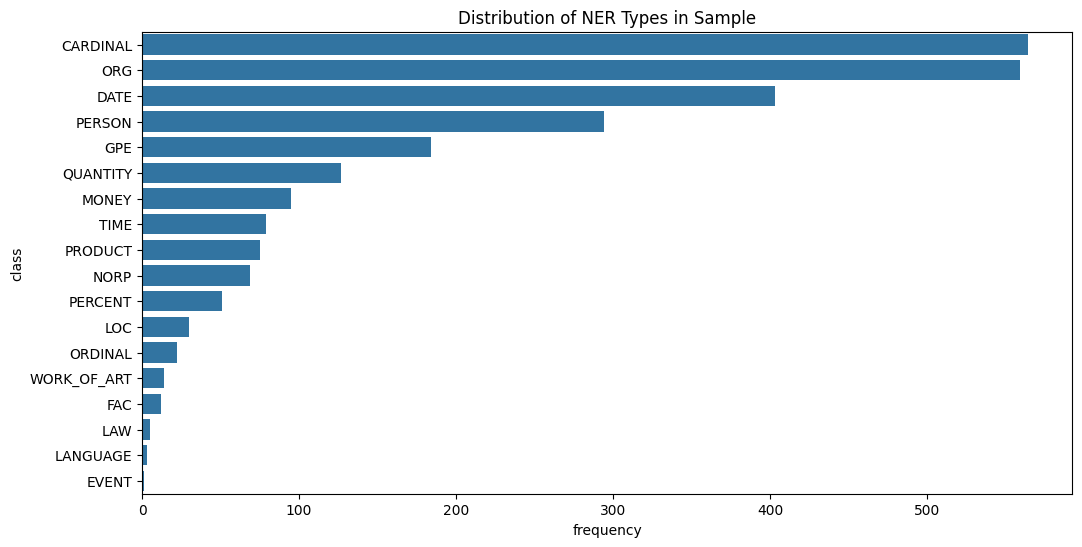

In [166]:
all_entities = [ent[1] for sublist in df_sample['entities'].tolist() for ent in sublist]
entity_df = pd.DataFrame(all_entities, columns=['entity'])

plt.figure(figsize=(12, 6))
sns.countplot(y='entity', data=entity_df, order=entity_df['entity'].value_counts().index)
plt.title('Distribution of NER Types in Sample')
plt.xlabel('frequency')
plt.ylabel('class')
plt.show()

When looking at an individual sample, it is evident that many tokens were misclassified, especially organisations, persons and locations (GPE). Drugs are often classified as either of those classes. The classification of dates and numbers is more correct. However, some numbers (eg. *Temperature 98.7*) and dates (eg. *07/2007*) were missed by the model, even these are values which should be easier to identify for the model. 

In [118]:
from spacy import displacy

text = df_sample['text'].iloc[0]
doc = nlp(text)

displacy.render(doc, style='ent')

## find out how to evaluate the quality of the NER classification and evaluate it automatically and manually with 100 randomly sampled entities

For the evaluation, we propose to label the entities of 10 randomly sampled texts. Because of the large text, this should result in more than 100 labeled entities. Then, we compare the predictions for these texts with our labels by looking at each sample and calculating metrics over all ten samples. 

The following code samples these texts and stores them in a text file to be used for annotation.

In [119]:
df_sample['text'].sample(10, random_state=12).to_csv('ner.txt', index=False, header=None, quoting=None)

The standard spacy NER model recognizes the following entities:

In [125]:
print('CARDINAL:', spacy.explain('CARDINAL'))
print('DATE:', spacy.explain('DATE'))
print('EVENT:', spacy.explain('EVENT'))
print('FAC:', spacy.explain('FAC'))
print('GPE:', spacy.explain('GPE'))
print('LANGUAGE:', spacy.explain('LANGUAGE'))
print('LAW:', spacy.explain('LAW'))
print('LOC:', spacy.explain('LOC'))
print('MONEY:', spacy.explain('MONEY'))
print('NORP:', spacy.explain('NORP'))
print('ORDINAL:', spacy.explain('ORDINAL'))
print('ORG:', spacy.explain('ORG'))
print('QUANTITY:', spacy.explain('QUANTITY'))
print('PERCENT:', spacy.explain('PERCENT'))
print('PERSON:', spacy.explain('PERSON'))
print('PRODUCT:', spacy.explain('PRODUCT'))
print('TIME:', spacy.explain('TIME'))
print('WORK_OF_ART:', spacy.explain('WORK_OF_ART'))

CARDINAL: Numerals that do not fall under another type
DATE: Absolute or relative dates or periods
EVENT: Named hurricanes, battles, wars, sports events, etc.
FAC: Buildings, airports, highways, bridges, etc.
GPE: Countries, cities, states
LANGUAGE: Any named language
LAW: Named documents made into laws.
LOC: Non-GPE locations, mountain ranges, bodies of water
MONEY: Monetary values, including unit
NORP: Nationalities or religious or political groups
ORDINAL: "first", "second", etc.
ORG: Companies, agencies, institutions, etc.
QUANTITY: Measurements, as of weight or distance
PERCENT: Percentage, including "%"
PERSON: People, including fictional
PRODUCT: Objects, vehicles, foods, etc. (not services)
TIME: Times smaller than a day
WORK_OF_ART: Titles of books, songs, etc.


In [120]:
import json
with open('ner_annotations.json', 'r') as file:
	test_data = json.load(file)

The identified entities in the ground truth matches with the manual observation of the texts. The most common classes are numeric values such as cardinal, quantity, date, ordinal and percent. Of the total 18 classes in the spacy model, only 10 were found in the text samples.

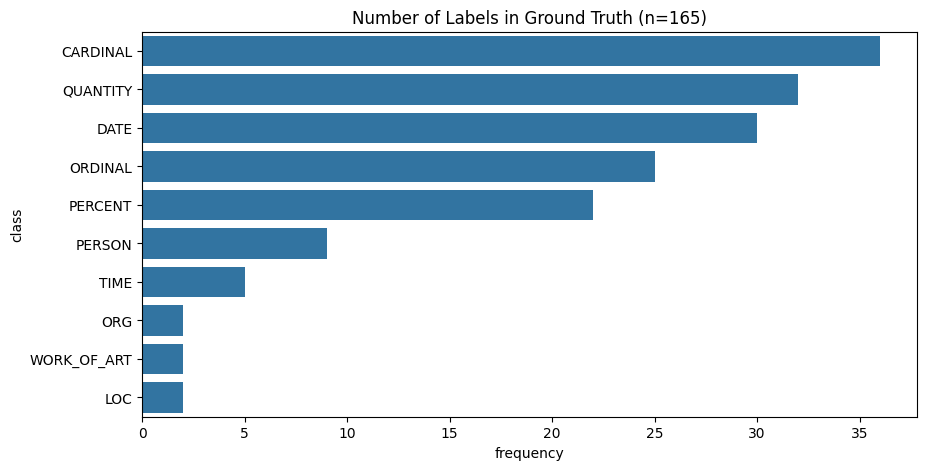

In [167]:
stats = {}
for text, annotations in test_data['annotations']:
	for start, end, label in annotations['entities']:
		stats[label] = stats[label] if label in stats else 0
		stats[label] += 1

chart_stats = pd.DataFrame.from_dict(stats, orient='index', columns=['n'])
chart_stats = chart_stats.reset_index(names='label')
chart_stats = chart_stats.sort_values('n', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(chart_stats, x='n', y='label')
plt.title(f'Number of Labels in Ground Truth (n={chart_stats["n"].sum()})')
plt.xlabel('frequency')
plt.ylabel('class')
plt.show()

We can now compare the annotations by the model with the ones from the ground truth. First, the model detected many more entities than there are apparent in the ground truth. Entities like organisations and products were often missidentified. Also, the model has problems identifying simple patterns like dates. Numerical are recogniozed well, but in some cases, the wrong class was attached to the labels. Quantities and dates get classified as cardinals.

In [174]:
i = 9
text, _ = test_data['annotations'][i]
doc = nlp(text)
displacy.render(doc, style='ent')

In [175]:
text, annotations = test_data['annotations'][i]
doc = nlp(text)
spans = [doc.char_span(start, end, label, alignment_mode='expand') for start, end, label in annotations['entities']]
spans = spacy.util.filter_spans(spans)
doc.ents = spans

displacy.render(doc, style='ent')

Next, we want to evaluate the recognized entities using quantitative strategies. For that, precision and recall are calculated for each entity class. All detected ordinals and percentages were also identified as such in the ground truth. And all percentages in the ground truth got successfully detected by the model, resulting in a recall of 1. Percentages seem to be easy detectable tokens as they always have the `%` suffix. Recall of ordinals is very low with around 0.2. Also, no correct entities for classes *person*, *work_of_art* and *loc* were found at all. The fact that the model detects organisations, which are not real organisations, is reflected by the low precision score. 

In [176]:
from spacy.scorer import Scorer, Example

scorer = Scorer()
examples = []
for text, annotations in test_data['annotations']:
	doc = nlp.make_doc(text)
	spans = [doc.char_span(start, end, label, alignment_mode='expand') for start, end, label in annotations['entities']]
	spans = spacy.util.filter_spans(spans)
	example = Example.from_dict(doc, {'entities': spans})
	example.predicted = nlp(str(example.predicted))

	examples.append(example)

scores = scorer.score(examples)


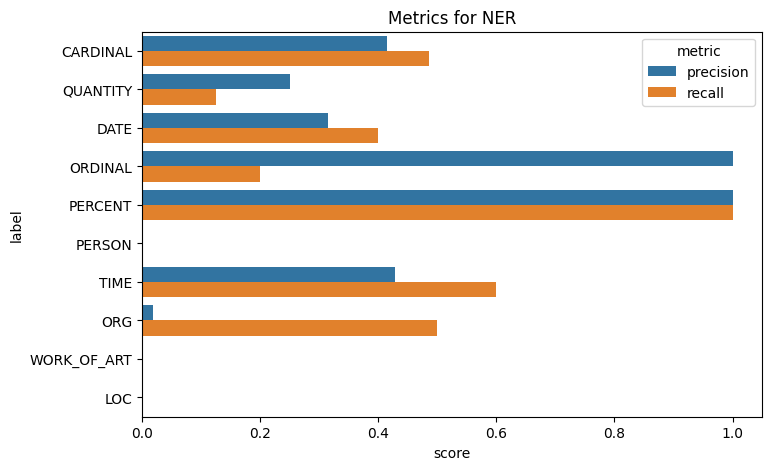

In [181]:
chart_scores = pd.DataFrame(scores['ents_per_type']).T[['p', 'r']].rename(columns={'p': 'precision', 'r': 'recall'}).reset_index(names='label').melt(['label'], var_name='metric', value_name='score')

plt.figure(figsize=(8, 5))
sns.barplot(chart_scores, x='score', y='label', hue='metric', order=chart_stats['label'])
plt.title('Metrics for NER')
plt.show()

Finally, we calculate precision and recall along with the F-score for all entities. The results are quite underwhelming with an F-score of about 0.30. However, as the ground truth consists of only 165 entities, it is not representative for the whole dataset, especially since the texts are rather diverse. Also, entities can be ambiguous and the manually annotated entities could look different, when annotated by another person. Manual inspection of the predictions is more time-consuming, but will deliver more insights than just a few metrics and difficult tokens can be identified more easily. 

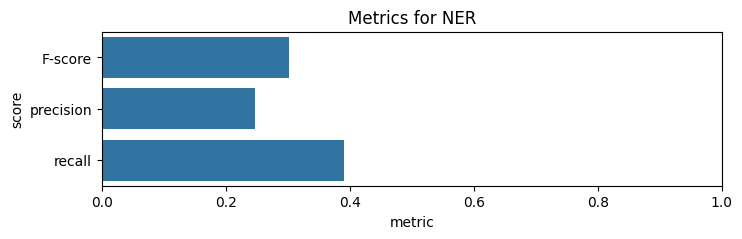

In [186]:
chart_scores = pd.DataFrame([
	{'metric': 'F-score', 'score': scores['ents_f']},
	{'metric': 'precision', 'score': scores['ents_p']},
	{'metric': 'recall', 'score': scores['ents_r']}
])

plt.figure(figsize=(8, 2))
sns.barplot(chart_scores, x='score', y='metric')
plt.title('Metrics for NER')
plt.xlabel('metric')
plt.ylabel('score')
plt.xlim(0, 1)
plt.show()

In [187]:
chart_scores

,metric,score
0,F-score,0.301887
1,precision,0.246154
2,recall,0.390244


## extend the standard NER types using the NER Annotator prodigy and re-run the NER classification as well as its evaluation

## Stuff

In [14]:
import json

results = []
for text in df_sample['text'].sample(10, random_state=12):
	doc = nlp(text)
	entities = []
	for ent in doc.ents:
		entities.append([ent.start, ent.end, ent.label_])

	results.append(
		[text, {'entities': entities}]
	)

with open('ner.json', 'w') as file:
	json.dump(results, file)